# A practical Guide to Feature Engineering in Python

Feature engineering is one of the most important skills needed in data science and machine learning. It has a major influence on the performance of machine learning models and even the quality of insights derived during exploratory data analysis (EDA).

In this article, we’re going to learn some important techniques and tools that will help you properly extract, prepare, and engineer features from your dataset.

https://heartbeat.fritz.ai/a-practical-guide-to-feature-engineering-in-python-8326e40747c8

Data from Kaggle:

https://www.kaggle.com/antfarol/car-sale-advertisements

https://www.kaggle.com/satadru5/car-sale-prediction

# 1. Importing the relevant libraries

In [108]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

# Modelling Helpers:
# from sklearn.preprocessing import Imputer, Normalizer, scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, ShuffleSplit, cross_validate
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
# Evaluation metrics for Classification
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV,ElasticNet,LogisticRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# Evaluation metrics for Regression 
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)

# Configuration
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


# 2. Common function

In [109]:
def Predictive_Model(num_df, cat_df, target):
    
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = pd.concat([num_df,cat_df],axis=1)
    else:
        input_df = num_df.copy()
    
    # scaling features for numerical vars
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(input_df)
    scaled_df = scaler.transform(input_df)
    input_df = pd.DataFrame(scaled_df, columns = input_df.columns)
        
    # train test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size=0.5, random_state=0, stratify = df[target])
    
    # build model
    from sklearn.ensemble import GradientBoostingClassifier
    # initiate model
    model = GradientBoostingClassifier()
    
    kfold = KFold(n_splits = 10, random_state = 10)
    scores = cross_val_score(model,X_train,y_train,cv=kfold,scoring='accuracy')
    print("Accuracy: %0.2f%% (+/- %0.2f%%)" % (100*scores.mean(), 100*scores.std()))
    
    # train model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    prob_train_pred = model.predict_proba(X_train)

    y_test_pred = model.predict(X_test)
    prob_test_pred = model.predict_proba(X_test)
    
    # print Rsquare of train set and test sest
    print('Train set score: ', accuracy_score(y_train, y_train_pred))
    print('Test set score: ', accuracy_score(y_test, y_test_pred))

In [110]:
# Distribution plot

def analyse_continuous(df,var,target):
    df = df.copy()
    # df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(20,5))
       
    # histogram
    plt.subplot(131)
    sns.distplot(df[var], bins=30)
    #sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title('Histogram')    
    
    # Q-Q plot
    plt.subplot(132)
    stats.probplot(df[var], dist="norm", plot=pylab)
    plt.ylabel('Quantiles')    
    
    # boxplot
    plt.subplot(133)
    sns.boxplot(x=df[var])
    plt.title('Boxplot')
          
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.show()

# 3. Loading the raw data

In [111]:
df = pd.read_csv('CarSale.csv')
org_df = df.copy()
df.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


# 4. Data Exploration

## 4.1. Descriptive Statistics

In [112]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4345,7,Volkswagen,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4173,NaN,NaN,NaN,19418.7,25584.2,600,6999,11500,21700,300000
Body,4345,6,sedan,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4345,NaN,NaN,NaN,161.237,105.706,0,86,155,230,980
EngineV,4195,NaN,NaN,NaN,2.79073,5.06644,0.6,1.8,2.2,3,99.99
Engine Type,4345,4,Diesel,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4345,2,yes,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4345,NaN,NaN,NaN,2006.55,6.7191,1969,2003,2008,2012,2016
Model,4345,312,E-Class,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.2. Investigating missing values

In [113]:
print('Original shape: ', df.shape)
df = df.dropna(axis=0)
print('After removing data: ', df.shape)

df = df.reset_index(drop=True)
cleaned_df = df.copy()

Original shape:  (4345, 9)
After removing data:  (4025, 9)


## 4.4. Investigate target var

### Define Target

In [114]:
df['Class'] = 0
df.loc[df.Price > 15000, 'Class'] = 1
df = df.drop(['Price'],axis=1)

df[df.Class == 0].shape, df[df.Class == 1].shape

((2535, 9), (1490, 9))

## 4.3. Categorize vars

In [115]:
target = 'Class'
cat_vars = [var for var in df.columns if df[var].dtypes == 'O' and var != target]
num_vars = [var for var in df.columns if df[var].dtypes != 'O' and var != target]

print('Taret: ', target)
print('Num vars: ', num_vars)
print('Cat vars: ', cat_vars)

Taret:  Class
Num vars:  ['Mileage', 'EngineV', 'Year']
Cat vars:  ['Brand', 'Body', 'Engine Type', 'Registration', 'Model']


### Distribution of target var

## 4.5. Explore numerical vars

### 4.5.1. Data Overview

In [116]:
df[num_vars].head()

,Mileage,EngineV,Year
0,277,2.0,1991
1,427,2.9,1999
2,358,5.0,2003
3,240,4.2,2007
4,120,2.0,2011


### 4.5.2. Explore distribution

#### Distribution of Independent Variable

Skewness: 0.700196
Kurtosis: 1.809798


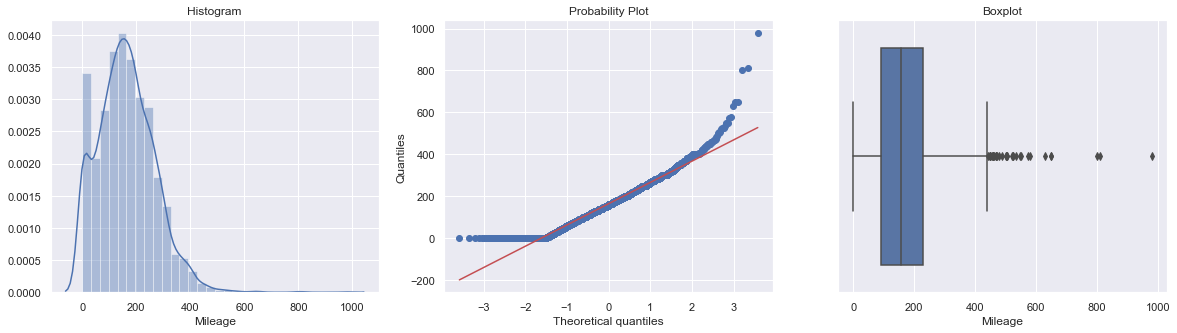

Skewness: 17.154962
Kurtosis: 316.181652


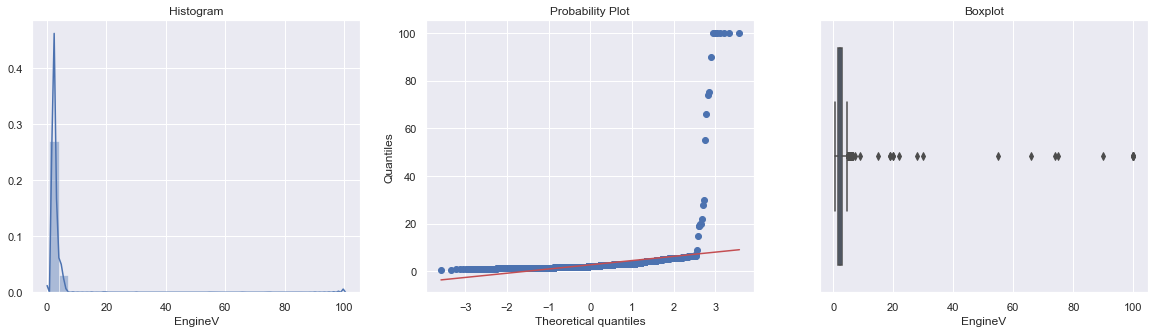

Skewness: -0.963945
Kurtosis: 0.999387


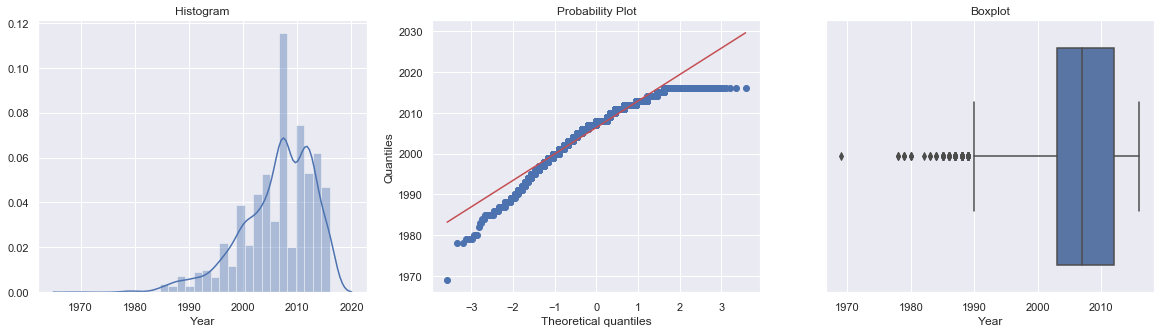

In [117]:
for var in num_vars:
    analyse_continuous(df,var,target)

#### Bivariate analysis

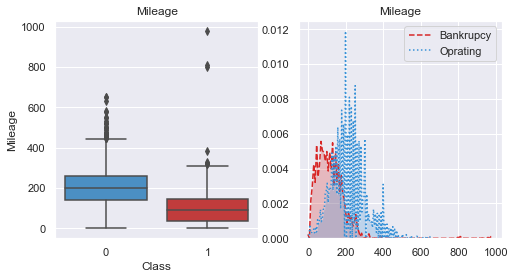

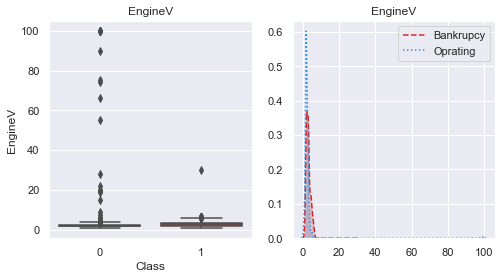

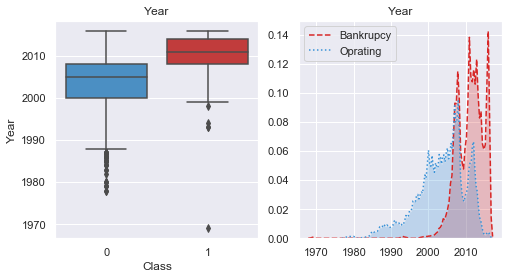

In [118]:
colors = ['#3791D7','#D72626']

for column in num_vars:    
    plt.figure(figsize=[8,4])
    plt.subplot(121)
    sns.boxplot(x='Class', y=column,data=df,palette=colors)
    plt.title(column, fontsize=12)
    plt.subplot(122)
    sns.kdeplot(df[df.Class==1][column], bw = 0.4, label = "Bankrupcy", shade=True, color="#D72626", linestyle="--")
    sns.kdeplot(df[df.Class==0][column], bw = 0.4, label = "Oprating", shade=True, color= "#3791D7", linestyle=":")
    plt.title(column, fontsize=12)
    plt.show()

#### Statistics test

In [119]:
import scipy


ttest_df = pd.DataFrame(columns = ['Feature','t-stats','p-value'])
ttest_df['Feature'] = num_vars

df0 = df[df['Class'] == 0]
df1 = df[df['Class'] == 1]

for var in num_vars:
    result = scipy.stats.ttest_ind(df0[var], df1[var])
    ttest_df.loc[ttest_df['Feature'] == var,'t-stats'] = result[0]
    ttest_df.loc[ttest_df['Feature'] == var,'p-value'] = result[1]
  
ttest_df

,Feature,t-stats,p-value
0,Mileage,36.2559,2.61373e-249
1,EngineV,-2.45385,0.0141755
2,Year,-40.4355,2.72294e-300


## 4.6. Explore categorical vars

## 4.7. Summary

# 5. Data Cleaning

# 6. Data Driven Story

# 7. Data Preprocessing and Engineering

## 7.1. Engineering numerical vars

### 7.1.1. Dealing with missing values

#### Removing rows with missing values

In [120]:
print('Original shape: ', df.shape)
df = df.dropna(axis=0)
print('After removing data: ', df.shape)

df = df.reset_index(drop=True)
cleaned_df = df.copy()

Original shape:  (4025, 9)
After removing data:  (4025, 9)


In [121]:
df.head()

,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class
0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0
1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0
2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0
3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1
4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1


### 7.1.2. Train model without preprocessing

In [122]:
num_df = df[num_vars]
cat_df = pd.DataFrame()
Predictive_Model(num_df, cat_df, target)

Accuracy: 89.36% (+/- 1.79%)
Train set score:  0.918986083499006
Test set score:  0.8966716343765524


### 7.1.3. Treating outliers

In [123]:
# function to find upper and lower boundaries
# for normally distributed variables

def find_normal_boundaries(df, variable):

    # calculate the boundaries outside which sit the outliers
    # for a Gaussian distribution

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [124]:
# function to find upper and lower boundaries
# for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [125]:
df.shape

(4025, 9)

#### Year

Skewness: -0.963945
Kurtosis: 0.999387


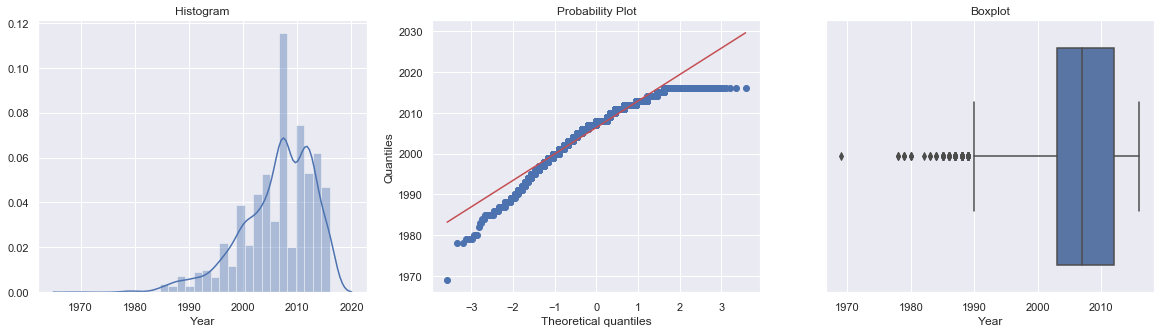

In [126]:
analyse_continuous(df,'Year',target)

In [127]:
# calculate boundaries for Year
upper_boundary, lower_boundary = find_normal_boundaries(df, 'Year')
upper_boundary, lower_boundary

(2026.46641322036, 1986.292841438025)

In [128]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Year (right end outliers): {}'.format(
    len(df[df['Year'] > upper_boundary])))

print('cars with less than lower_boundary of Year (left end outliers: {}'.format(
    len(df[df['Year'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['Year'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['Year'] < lower_boundary]) / len(df)))

total number of Year: 4025
cars with more than upper_boundary of Year (right end outliers): 0
cars with less than lower_boundary of Year (left end outliers: 38

% right end outliers: 0.0
% left end outliers: 0.009440993788819876


In [129]:
df = df[(df.Year < upper_boundary) & (df.Year > lower_boundary)]
df = df.reset_index(drop=True)
df.shape

(3987, 9)

Skewness: -0.762869
Kurtosis: 0.201604


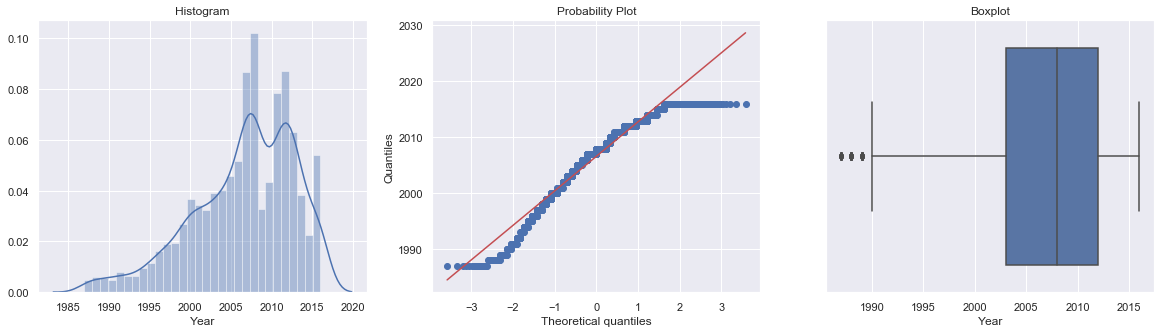

In [130]:
analyse_continuous(df,'Year',target)

#### Mileage

Skewness: 0.706495
Kurtosis: 1.868399


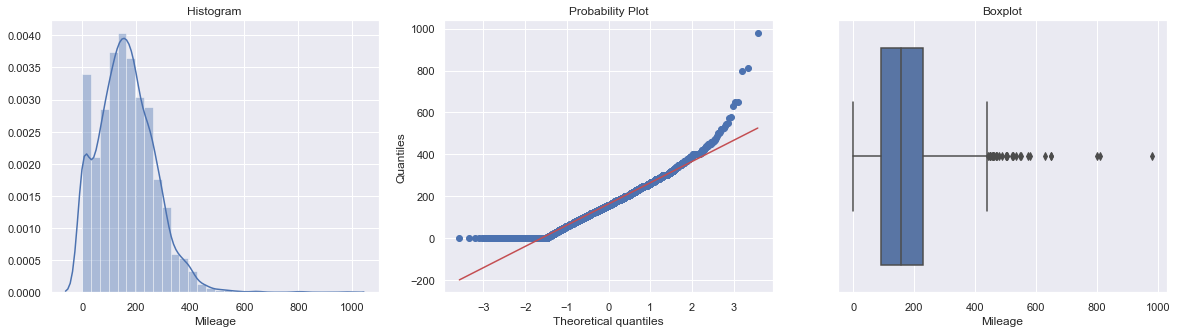

In [131]:
analyse_continuous(df,'Mileage',target)

In [132]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

upper_boundary, lower_boundary = find_skewed_boundaries(df, 'Mileage', 2)
upper_boundary, lower_boundary

(510.0, -190.0)

In [133]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Mileage (right end outliers): {}'.format(
    len(df[df['Mileage'] > upper_boundary])))

print('cars with less than lower_boundary of Mileage (left end outliers: {}'.format(
    len(df[df['Mileage'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['Mileage'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['Mileage'] < lower_boundary]) / len(df)))

total number of Year: 3987
cars with more than upper_boundary of Mileage (right end outliers): 14
cars with less than lower_boundary of Mileage (left end outliers: 0

% right end outliers: 0.003511412089290193
% left end outliers: 0.0


In [134]:
df = df[(df.Mileage < upper_boundary) & (df.Mileage > lower_boundary)]
df = df.reset_index(drop = True)
df.shape

(3973, 9)

Skewness: 0.368103
Kurtosis: -0.178503


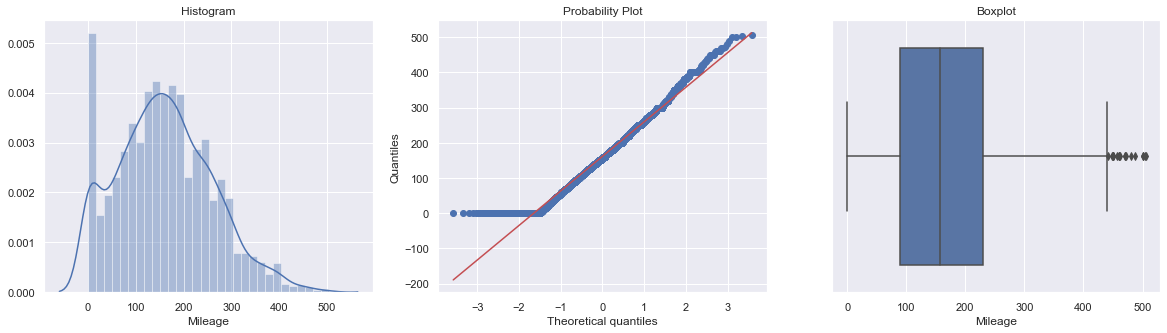

In [135]:
analyse_continuous(df,'Mileage',target)

#### EngineV

Skewness: 17.049629
Kurtosis: 312.213441


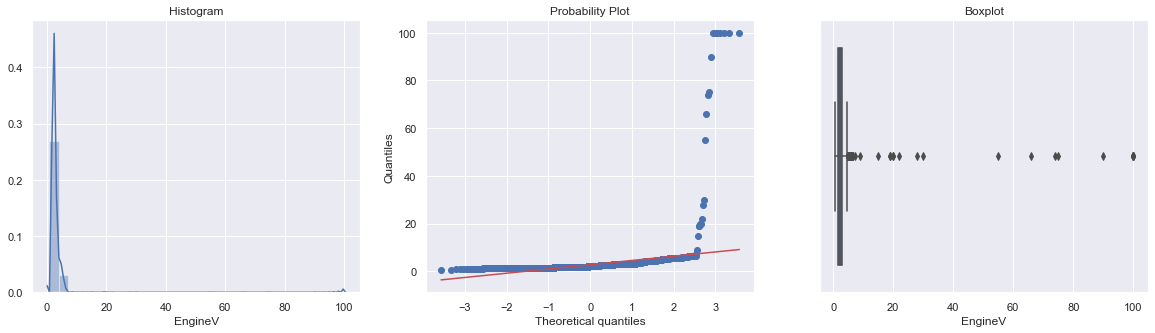

In [136]:
analyse_continuous(df,'EngineV',target)

In [137]:
# looking for outliers,
# using the interquantile proximity rule
# IQR * 1.5, the standard metric

# for LSTAT in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(df, 'EngineV', 5)
upper_boundary, lower_boundary

(9.0, -4.2)

In [138]:
# inspect the number and percentage of outliers for RM

print('total number of Year: {}'.format(len(df)))

print('cars with more than upper_boundary of Mileage (right end outliers): {}'.format(
    len(df[df['EngineV'] > upper_boundary])))

print('cars with less than lower_boundary of Mileage (left end outliers: {}'.format(
    len(df[df['EngineV'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(df[df['EngineV'] > upper_boundary]) / len(df)))

print('% left end outliers: {}'.format(
    len(df[df['EngineV'] < lower_boundary]) / len(df)))

total number of Year: 3973
cars with more than upper_boundary of Mileage (right end outliers): 20
cars with less than lower_boundary of Mileage (left end outliers: 0

% right end outliers: 0.005033979360684621
% left end outliers: 0.0


In [139]:
df = df[(df.EngineV < upper_boundary) & (df.EngineV > lower_boundary)]
df = df.reset_index()
df.shape

(3952, 10)

Skewness: 1.492797
Kurtosis: 2.256621


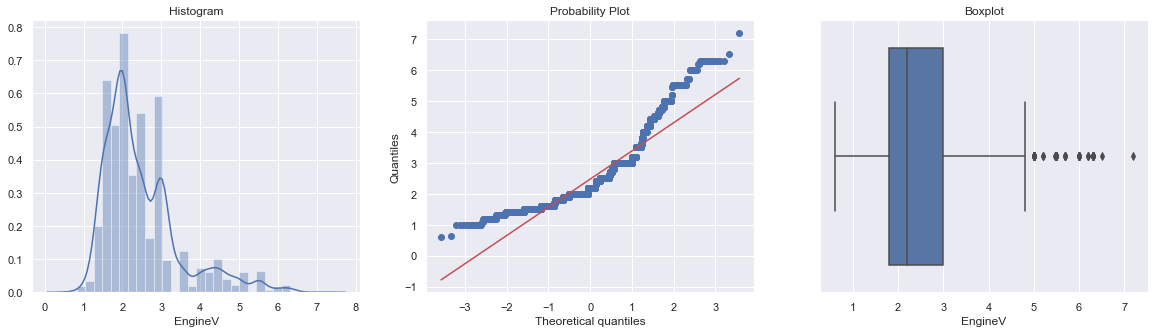

In [140]:
analyse_continuous(df,'EngineV',target)

#### Training model

In [141]:
df = df.reset_index(drop = True)
num_df = df[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Accuracy: 89.73% (+/- 1.96%)
Train set score:  0.9286437246963563
Test set score:  0.8992914979757085


### 7.1.4. Gaussian Transformation

+ transform Price to have linear relationship

#### Transform independent vars to have Normal distribution

Skewness: 0.563818
Kurtosis: 0.065022


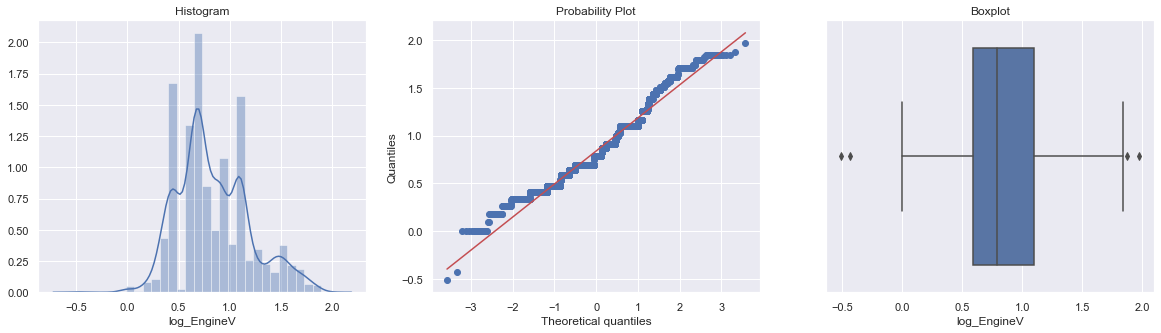

In [142]:
df['log_EngineV'] = np.log(df['EngineV'])
analyse_continuous(df,'log_EngineV',target)

Skewness: -0.770464
Kurtosis: 0.225049


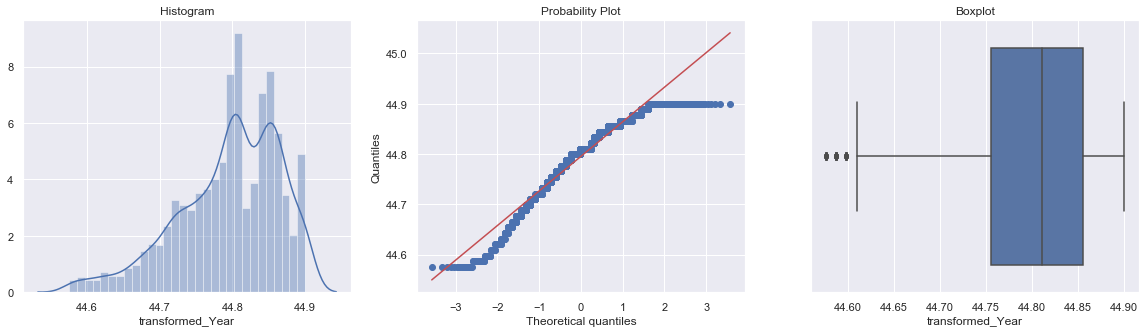

In [143]:
df['transformed_Year'] = df.Year**(1/2)
analyse_continuous(df,'transformed_Year',target)

In [144]:
num_vars  = ['transformed_Year','Mileage','log_EngineV']
num_df = df[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Accuracy: 89.78% (+/- 1.91%)
Train set score:  0.9286437246963563
Test set score:  0.8992914979757085


In [145]:
num_vars  = ['Year','Mileage','log_EngineV']
num_df = df[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Accuracy: 89.78% (+/- 1.91%)
Train set score:  0.9286437246963563
Test set score:  0.8992914979757085


## 7.2. Engineering categorical vars

### 7.2.1. Data Overview

In [146]:
df[cat_vars].head()

,Brand,Body,Engine Type,Registration,Model
0,BMW,sedan,Petrol,yes,320
1,Mercedes-Benz,van,Diesel,yes,Sprinter 212
2,Mercedes-Benz,sedan,Gas,yes,S 500
3,Audi,crossover,Petrol,yes,Q7
4,Toyota,crossover,Petrol,yes,Rav 4


### 7.2.2. Engineering mixed vars

https://www.geeksforgeeks.org/python-extract-numbers-from-string/

https://towardsdatascience.com/encoding-categorical-features-21a2651a065c

https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

https://heartbeat.fritz.ai/a-practical-guide-to-feature-engineering-in-python-8326e40747c8


In [147]:
print(len(df.Model.unique()))
df.Model.unique()

301


array(['320', 'Sprinter 212', 'S 500', 'Q7', 'Rav 4', 'GLS 63', 'A6',
       'Megane', 'Golf IV', '19', 'A6 Allroad', 'Passat B6',
       'Land Cruiser 100', 'Clio', '318', 'Hilux', 'Polo', 'Outlander',
       'A8', 'Touareg', 'Vito', 'Colt', '100', 'Z4', 'Pajero Wagon', 'X5',
       'Caddy', 'Camry', '528', 'TT', 'G 55 AMG', 'X6', 'Galant', '525',
       'Kangoo', 'ML 350', '730', 'Trafic', 'X5 M', 'S 350', 'Lancer',
       'E-Class', 'Scenic', '330', 'Passat B5', 'A3',
       'Land Cruiser Prado', 'Caravelle', 'Avensis', 'GL 320', 'GL 450',
       'Lancer X', '200', '520', 'Tiguan', 'Outlander XL', 'GLS 350',
       'A5', 'X6 M', 'Golf III', 'A 150', 'FJ Cruiser', 'Koleos',
       'Land Cruiser 200', 'Passat B7', 'Scirocco', 'M5', 'Venza',
       'V 250', 'ML 270', 'C-Class', 'Lupo', '5 Series', 'CLA 200',
       'T5 (Transporter)', 'Highlander', 'Corolla', 'CLK 240', 'I3',
       'Multivan', 'Vaneo', 'X1', 'T5 (Transporter) ', 'S 400', 'S 550',
       'Passat CC', 'A4 Allroad', 'Pas

#### Create dummy vars for all labels without removing first var

In [170]:
dummy_df = pd.get_dummies(df.Model, drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 300)


,100,11,116,118,120,19,190,200,210,220,230,25,250,300,316,318,320,323,324,325,328,330,335,4 Series Gran Coupe,428,4Runner,5,5 Series,5 Series GT,520,523,524,525,528,530,535,540,545,550,6 Series Gran Coupe,630,640,645,650,730,735,740,745,750,760,80,9,90,A 140,A 150,A 170,A 180,A1,A3,A4,A4 Allroad,A5,A6,A6 Allroad,A7,A8,ASX,Amarok,Auris,Avalon,Avensis,Aygo,B 170,B 180,B 200,Beetle,Bora,C-Class,CL 180,CL 500,CL 55 AMG,CL 550,CL 63 AMG,CLA 200,CLA 220,CLA-Class,CLC 180,CLC 200,CLK 200,CLK 220,CLK 230,CLK 240,CLK 280,CLK 320,CLK 430,CLS 350,CLS 400,CLS 500,CLS 63 AMG,Caddy,Camry,Captur,Caravelle,Carina,Carisma,Celica,Clio,Colt,Corolla,Corolla Verso,Cross Touran,Dokker,Duster,E-Class,Eclipse,Eos,Espace,FJ Cruiser,Fluence,Fortuner,G 320,G 350,G 500,G 55 AMG,G 63 AMG,GL 320,GL 350,GL 420,GL 450,GL 500,GL 550,GLC-Class,GLE-Class,GLK 220,GLK 300,GLS 350,GLS 400,GLS 500,GLS 63,Galant,Golf GTI,Golf II,Golf III,Golf IV,Golf Plus,Golf V,Golf VI,Golf VII,Golf Variant,Grand Scenic,Grandis,Hiace,Highlander,Hilux,I3,IQ,Jetta,Kangoo,Koleos,L 200,LT,Laguna,Lancer,Lancer Evolution,Lancer X,Lancer X Sportback,Land Cruiser 100,Land Cruiser 105,Land Cruiser 200,Land Cruiser 76,Land Cruiser 80,Land Cruiser Prado,Latitude,Logan,Lupo,M5,M6,MB,ML 250,ML 270,ML 280,ML 320,ML 350,ML 400,ML 430,ML 500,ML 550,ML 63 AMG,Mark II,Master,Matrix,Megane,Modus,Multivan,New Beetle,Outlander,Outlander XL,Pajero,Pajero Pinin,Pajero Sport,Pajero Wagon,Passat B2,Passat B3,Passat B4,Passat B5,Passat B6,Passat B7,Passat B8,Passat CC,Phaeton,Pointer,Polo,Previa,Prius,Q3,Q5,Q7,R 320,R8,Rav 4,S 140,S 250,S 300,S 320,S 350,S 400,S 420,S 430,S 500,S 550,S 600,S 63 AMG,S 65 AMG,S-Guard,S4,S5,S8,SL 500 (550),SL 55 AMG,SLK 200,SLK 350,Sandero,Sandero StepWay,Scenic,Scion,Scirocco,Sequoia,Sharan,Sienna,Smart,Space Star,Space Wagon,Sprinter,Sprinter 208,Sprinter 210,Sprinter 211,Sprinter 212,Sprinter 213,Sprinter 311,Sprinter 312,Sprinter 313,Sprinter 315,Sprinter 316,Sprinter 318,Sprinter 319,Sprinter 324,Symbol,Syncro,T3 (Transporter),T4 (Transporter),T4 (Transporter),T5 (Transporter),T5 (Transporter),T6 (Transporter),T6 (Transporter),TT,Tacoma,Tiguan,Touareg,Touran,Trafic,Tundra,Up,V 250,Vaneo,Vento,Venza,Viano,Virage,Vista,Vito,X1,X3,X5,X5 M,X6,X6 M,Yaris,Z3,Z4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [171]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.37% (+/- 1.58%)
Train set score:  0.9524291497975709
Test set score:  0.9200404858299596


#### Extract numerical part and categorical part

In [241]:
import re 

def LetterPart_Extraction(init_string):
    # letter_part = " ".join(re.findall("[a-zA-Z]+", ini_string)) 
    letter_part = ''.join(filter(lambda chr: chr.isalpha(), init_string))
    return letter_part

def NumberPart_Extraction(init_string):
    # number_part = [int(s) for s in init_string.split() if s.isdigit()]
    number_part = ''.join(filter(lambda i: i.isdigit(), init_string))
    # number_part = list(map(int, re.findall(r'\d+', init_string))) 
    return number_part

df['Model_categorical'] = df.Model.apply(lambda x:LetterPart_Extraction(x))
df['Model_numerical'] = df.Model.apply(lambda x:NumberPart_Extraction(x))
df.head(5)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical
0,0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0,0.693147,44.620623,,320,OO,320.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212,NaN,0.0,Sp,212.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500,NaN,0.0,S,500.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7,NaN,0.0,NaN,0.0,Q,7.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4,NaN,0.0,NaN,0.0,NaN,0.0,Ra,4.0,NaN,0.0,NaN,0.0,NaN,0.0


In [242]:
print(len(df.Model_categorical.unique()))
df.Model_categorical.unique()

153


array(['', 'Sprinter', 'S', 'Q', 'Rav', 'GLS', 'A', 'Megane', 'GolfIV',
       'AAllroad', 'PassatB', 'LandCruiser', 'Clio', 'Hilux', 'Polo',
       'Outlander', 'Touareg', 'Vito', 'Colt', 'Z', 'PajeroWagon', 'X',
       'Caddy', 'Camry', 'TT', 'GAMG', 'Galant', 'Kangoo', 'ML', 'Trafic',
       'XM', 'Lancer', 'EClass', 'Scenic', 'LandCruiserPrado',
       'Caravelle', 'Avensis', 'GL', 'LancerX', 'Tiguan', 'OutlanderXL',
       'GolfIII', 'FJCruiser', 'Koleos', 'Scirocco', 'M', 'Venza', 'V',
       'CClass', 'Lupo', 'Series', 'CLA', 'TTransporter', 'Highlander',
       'Corolla', 'CLK', 'I', 'Multivan', 'Vaneo', 'PassatCC', 'GolfII',
       'L', 'Jetta', 'Logan', 'PajeroSport', 'LancerXSportback',
       'GolfPlus', 'Up', 'Amarok', 'G', 'Auris', 'CL', 'Master', 'Dokker',
       'GolfVI', 'GolfVII', 'Laguna', 'NewBeetle', 'Pajero', 'Viano',
       'Sharan', 'Prius', 'B', 'Fluence', 'Duster', 'Hiace', 'CLC',
       'GolfV', 'Fortuner', 'LT', 'Symbol', 'Yaris', 'Espace',
       'GolfVaria

In [243]:
df['Model_categorical'] = df['Model_categorical'].replace('','1')
df['Model_categorical'].unique()

array(['1', 'Sprinter', 'S', 'Q', 'Rav', 'GLS', 'A', 'Megane', 'GolfIV',
       'AAllroad', 'PassatB', 'LandCruiser', 'Clio', 'Hilux', 'Polo',
       'Outlander', 'Touareg', 'Vito', 'Colt', 'Z', 'PajeroWagon', 'X',
       'Caddy', 'Camry', 'TT', 'GAMG', 'Galant', 'Kangoo', 'ML', 'Trafic',
       'XM', 'Lancer', 'EClass', 'Scenic', 'LandCruiserPrado',
       'Caravelle', 'Avensis', 'GL', 'LancerX', 'Tiguan', 'OutlanderXL',
       'GolfIII', 'FJCruiser', 'Koleos', 'Scirocco', 'M', 'Venza', 'V',
       'CClass', 'Lupo', 'Series', 'CLA', 'TTransporter', 'Highlander',
       'Corolla', 'CLK', 'I', 'Multivan', 'Vaneo', 'PassatCC', 'GolfII',
       'L', 'Jetta', 'Logan', 'PajeroSport', 'LancerXSportback',
       'GolfPlus', 'Up', 'Amarok', 'G', 'Auris', 'CL', 'Master', 'Dokker',
       'GolfVI', 'GolfVII', 'Laguna', 'NewBeetle', 'Pajero', 'Viano',
       'Sharan', 'Prius', 'B', 'Fluence', 'Duster', 'Hiace', 'CLC',
       'GolfV', 'Fortuner', 'LT', 'Symbol', 'Yaris', 'Espace',
       'GolfVari

In [244]:
df['Model_numerical'] = df['Model_numerical'].replace('',-1)
df['Model_numerical'] = df['Model_numerical'].astype(float)

In [245]:
df.Brand.unique()

array(['BMW', 'Mercedes-Benz', 'Audi', 'Toyota', 'Renault', 'Volkswagen',
       'Mitsubishi'], dtype=object)

In [246]:
df[df.Brand == 'BMW'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['1', 'Z', 'X', 'XM', 'M', 'Series', 'I', 'SeriesGT',
       'SeriesGranCoupe'], dtype=object)

In [314]:
df['BMW_categorical'] = 'Other'
df.loc[(df.Brand == 'BMW') ,'BMW_categorical'] = df['Model_categorical'].str[0]
df['BMW_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'BMW'),'BMW_numerical'] = 0

In [315]:
df.head(10)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.5,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.0,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.7,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.5,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.8,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [316]:
df.BMW_categorical.unique()

array(['1', 'Other', 'Z', 'X', 'M', 'S', 'I'], dtype=object)

In [250]:
df[df.Brand == 'Mercedes-Benz'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['Sprinter', 'S', 'GLS', 'Vito', 'GAMG', 'ML', 'EClass', 'GL', '1',
       'A', 'V', 'CClass', 'CLA', 'CLK', 'Vaneo', 'G', 'CL', 'Viano', 'B',
       'CLC', 'CLAMG', 'GLEClass', 'SAMG', 'SLK', 'MLAMG', 'GLK', 'CLS',
       'R', 'Smart', 'SL', 'MB', 'CLSAMG', 'CLAClass', 'SGuard',
       'GLCClass', 'SLAMG'], dtype=object)

In [317]:
df['MB_categorical'] = 'Other'
df.loc[(df.Brand == 'Mercedes-Benz'),'MB_categorical'] = df['Model_categorical'].str[0]
df['MB_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Mercedes-Benz'),'MB_numerical'] = 0

In [318]:
df.head(10)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.5,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.0,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.7,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.5,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.8,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [319]:
len(df.MB_categorical.unique())

11

In [323]:
df[df.Brand == 'Audi'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['Q', 'A', 'AAllroad', '1', 'TT', 'R', 'S'], dtype=object)

In [324]:
df['Audi_categorical'] = 'Other'
df.loc[(df.Brand == 'Audi'),'Audi_categorical'] = df['Model_categorical'].str[0]
df['Audi_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Audi'),'Audi_numerical'] = 0

In [325]:
df.head(10)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.0,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.9,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.0,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.2,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.0,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.5,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.0,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.7,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.5,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.8,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [326]:
len(df.Audi_categorical.unique())

7

In [327]:
df[df.Brand == 'Toyota'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['Rav', 'LandCruiser', 'Hilux', 'Camry', 'LandCruiserPrado',
       'Avensis', 'FJCruiser', 'Venza', 'Highlander', 'Corolla', 'Auris',
       'Prius', 'Hiace', 'Fortuner', 'Yaris', 'Tacoma', 'IQ', 'Celica',
       'Tundra', 'Sienna', 'Previa', 'Vista', 'Carina', 'Avalon', 'Aygo',
       'Matrix', 'MarkII', 'CorollaVerso', 'Runner', 'Sequoia', 'Scion'],
      dtype=object)

In [328]:
df['Toyota_categorical'] = 'Other'
df.loc[(df.Brand == 'Toyota'),'Toyota_categorical'] = df['Model_categorical'].str[0]
df['Toyota_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Toyota'),'Toyota_numerical'] = 0

In [329]:
df.head(30)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.00,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.90,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.00,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.20,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.00,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.50,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.00,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.70,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.50,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.80,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [330]:
len(df.Toyota_categorical.unique())

14

In [331]:
df[df.Brand == 'Renault'][['Model','Model_categorical','Model_numerical']].Model.unique()

array(['Megane', '19', 'Clio', 'Kangoo', 'Trafic', 'Scenic', 'Koleos',
       'Logan', 'Master', 'Dokker', 'Laguna', 'Fluence', 'Duster',
       'Symbol', 'Espace', 'Grand Scenic', 'Sandero', 'Latitude', '25',
       '5', '9', 'Modus', 'Captur', 'Sandero StepWay', '11'], dtype=object)

In [332]:
df['Renault_categorical'] = 'Other'
df.loc[(df.Brand == 'Renault'),'Renault_categorical'] = df['Model_categorical'].str[0]
df['Renault_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Renault'),'Renault_numerical'] = 0

In [333]:
df.head(20)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.00,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.90,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.00,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.20,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.00,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.50,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.00,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.70,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.50,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.80,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [334]:
len(df.Renault_categorical.unique())

12

In [335]:
df[df.Brand == 'Volkswagen'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['GolfIV', 'PassatB', 'Polo', 'Touareg', 'Caddy', 'Caravelle',
       'Tiguan', 'GolfIII', 'Scirocco', 'Lupo', 'TTransporter',
       'Multivan', 'PassatCC', 'GolfII', 'Jetta', 'GolfPlus', 'Up',
       'Amarok', 'GolfVI', 'GolfVII', 'NewBeetle', 'Sharan', 'GolfV',
       'LT', 'GolfVariant', 'Touran', 'Phaeton', 'Bora', 'Vento',
       'Beetle', 'CrossTouran', 'Pointer', 'Eos', 'GolfGTI', 'Syncro'],
      dtype=object)

In [336]:
df['Volkswagen_categorical'] = 'Other'
df.loc[(df.Brand == 'Volkswagen'),'Volkswagen_categorical'] = df['Model_categorical'].str[0]
df['Volkswagen_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Volkswagen'),'Volkswagen_numerical'] = 0

In [337]:
df.head(20)

,index,Brand,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,Class,log_EngineV,transformed_Year,Model_categorical,Model_numerical,BMW_categorical,BMW_numerical,MB_categorical,MB_numerical,Audi_categorical,Audi_numerical,Toyota_categorical,Toyota_numerical,Renault_categorical,Renault_numerical,Volkswagen_categorical,Volkswagen_numerical,Mitsubishi_categorical,Mitsubishi_numerical,Model_categorical_freq_imp,Model_categorical_rare_imp,Model_categorical_grouped
0,0,BMW,sedan,277,2.00,Petrol,yes,1991,320,0,0.693147,44.620623,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
1,1,Mercedes-Benz,van,427,2.90,Diesel,yes,1999,Sprinter 212,0,1.064711,44.710178,Sprinter,212.0,Other,0.0,S,212.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
2,2,Mercedes-Benz,sedan,358,5.00,Gas,yes,2003,S 500,0,1.609438,44.754888,S,500.0,Other,0.0,S,500.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,S,S,S
3,3,Audi,crossover,240,4.20,Petrol,yes,2007,Q7,1,1.435085,44.799554,Q,7.0,Other,0.0,Other,0.0,Q,7.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Q,Q,Q
4,4,Toyota,crossover,120,2.00,Petrol,yes,2011,Rav 4,1,0.693147,44.844175,Rav,4.0,Other,0.0,Other,0.0,Other,0.0,R,4.0,Other,0.0,Other,0.0,Other,0.0,Rav,Rav,Rav
5,5,Mercedes-Benz,crossover,0,5.50,Petrol,yes,2016,GLS 63,1,1.704748,44.899889,GLS,63.0,Other,0.0,G,63.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,Rare,rare
6,6,BMW,sedan,438,2.00,Gas,yes,1997,320,0,0.693147,44.687806,1,320.0,1,320.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,1,1,1
7,7,Audi,vagon,200,2.70,Diesel,yes,2006,A6,0,0.993252,44.788391,A,6.0,Other,0.0,Other,0.0,A,6.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,A,A,A
8,8,Renault,vagon,193,1.50,Diesel,yes,2012,Megane,0,0.405465,44.855323,Megane,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,M,-1.0,Other,0.0,Other,0.0,Megane,Megane,Megane
9,9,Volkswagen,other,212,1.80,Gas,no,1999,Golf IV,0,0.587787,44.710178,GolfIV,-1.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,Other,0.0,G,-1.0,Other,0.0,1,Rare,rare


In [338]:
len(df.Volkswagen_categorical.unique())

15

In [339]:
df[df.Brand == 'Mitsubishi'][['Model','Model_categorical','Model_numerical']].Model_categorical.unique()

array(['Outlander', 'Colt', 'PajeroWagon', 'Galant', 'Lancer', 'LancerX',
       'OutlanderXL', 'L', 'PajeroSport', 'LancerXSportback', 'Pajero',
       'PajeroPinin', 'Grandis', 'ASX', 'SpaceStar', 'Carisma', 'Eclipse',
       'Virage', 'SpaceWagon', 'LancerEvolution'], dtype=object)

In [340]:
df['Mitsubishi_categorical'] = 'Other'
df.loc[(df.Brand == 'Mitsubishi'),'Mitsubishi_categorical'] = df['Model_categorical'].str[0]
df['Mitsubishi_numerical'] = df.Model_numerical
df.loc[(df.Brand != 'Mitsubishi'),'Mitsubishi_numerical'] = 0

In [341]:
len(df.Mitsubishi_categorical.unique())

10

In [342]:
dummy_df = pd.get_dummies(df[['Brand','Engine Type','Body','Registration',
                              'BMW_categorical', 'MB_categorical', 'Audi_categorical', 'Toyota_categorical', 
                              'Renault_categorical', 'Volkswagen_categorical', 'Mitsubishi_categorical']], drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 84)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Registration_yes,BMW_categorical_I,BMW_categorical_M,BMW_categorical_Other,BMW_categorical_S,BMW_categorical_X,BMW_categorical_Z,MB_categorical_A,MB_categorical_B,MB_categorical_C,MB_categorical_E,MB_categorical_G,MB_categorical_M,MB_categorical_Other,MB_categorical_R,MB_categorical_S,MB_categorical_V,Audi_categorical_A,Audi_categorical_Other,Audi_categorical_Q,Audi_categorical_R,Audi_categorical_S,Audi_categorical_T,Toyota_categorical_C,Toyota_categorical_F,Toyota_categorical_H,Toyota_categorical_I,Toyota_categorical_L,Toyota_categorical_M,Toyota_categorical_Other,Toyota_categorical_P,Toyota_categorical_R,Toyota_categorical_S,Toyota_categorical_T,Toyota_categorical_V,Toyota_categorical_Y,Renault_categorical_C,Renault_categorical_D,Renault_categorical_E,Renault_categorical_F,Renault_categorical_G,Renault_categorical_K,Renault_categorical_L,Renault_categorical_M,Renault_categorical_Other,Renault_categorical_S,Renault_categorical_T,Volkswagen_categorical_B,Volkswagen_categorical_C,Volkswagen_categorical_E,Volkswagen_categorical_G,Volkswagen_categorical_J,Volkswagen_categorical_L,Volkswagen_categorical_M,Volkswagen_categorical_N,Volkswagen_categorical_Other,Volkswagen_categorical_P,Volkswagen_categorical_S,Volkswagen_categorical_T,Volkswagen_categorical_U,Volkswagen_categorical_V,Mitsubishi_categorical_C,Mitsubishi_categorical_E,Mitsubishi_categorical_G,Mitsubishi_categorical_L,Mitsubishi_categorical_O,Mitsubishi_categorical_Other,Mitsubishi_categorical_P,Mitsubishi_categorical_S,Mitsubishi_categorical_V
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [345]:
dummy_df = pd.get_dummies(df[['Brand','Engine Type','Body','Registration']], drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 15)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Registration_yes
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [346]:
num_df = df[['Year','Mileage','log_EngineV',
            'BMW_numerical', 'MB_numerical', 'Audi_numerical', 'Toyota_numerical', 
                              'Renault_numerical', 'Volkswagen_numerical', 'Mitsubishi_numerical']]

In [385]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.78% (+/- 1.70%)
Train set score:  0.9686234817813765
Test set score:  0.9331983805668016


In [386]:
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = pd.concat([num_df,cat_df],axis=1)
    else:
        input_df = num_df.copy()

In [387]:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])


In [388]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(kernel="linear")))
models.append(('LSVC', SVC(kernel="rbf")))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('LGB',LGBMClassifier()))
models.append(('ADA',AdaBoostClassifier()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('NN',MLPClassifier()))
models.append(('XGB',XGBClassifier()))

In [389]:
# Test options and evaluation metric
seed = 9
scoring = 'accuracy'

In [390]:
# evaluate each model in turn
results = {}
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.835679 (0.018687)
SVC: 0.913634 (0.014698)
LSVC: 0.779009 (0.024043)
LR: 0.849536 (0.024756)
DT: 0.921730 (0.010742)
GNB: 0.756072 (0.013597)
RF: 0.942307 (0.016747)
GB: 0.941637 (0.014115)
LGB: 0.945348 (0.015119)
ADA: 0.934889 (0.012779)
QDA: 0.589711 (0.033665)
NN: 0.849851 (0.039245)
XGB: 0.937922 (0.012352)


In [391]:
def ModelEvaluation(models):
    
    for name,model in models:
        print(name)
        model.fit(X_train, y_train)
        
        print('==========================================================')
        print('Train set')
        y_train_pred = model.predict(X_train)
        print('Accuracy: ', accuracy_score(y_train, list(y_train_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_train, list(y_train_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_train,list(y_train_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_train, list(y_train_pred)))
  
        print('----------------------------------------------------------')
        print('Test set')
        y_test_pred = model.predict(X_test)
        print('Accuracy: ', accuracy_score(y_test, list(y_test_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_test, list(y_test_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_test,list(y_test_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_test, list(y_test_pred)))
        print('==========================================================')
        
ModelEvaluation(models)

KNN
Train set
Accuracy:  0.893387314439946
ROC AUC Score:  0.8790606045902275
Confusion matrix
True          0    1
Predicted           
0          1733  117
1           199  915
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1850
           1       0.89      0.82      0.85      1114

    accuracy                           0.89      2964
   macro avg       0.89      0.88      0.88      2964
weighted avg       0.89      0.89      0.89      2964

----------------------------------------------------------
Test set
Accuracy:  0.8441295546558705
ROC AUC Score:  0.8236183253461012
Confusion matrix
True         0    1
Predicted          
0          559   58
1           96  275
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       617
           1       0.83      0.74      0.78       371

    accuracy                           0.84       988
   macro avg       0.84      0.82      0.83   

Train set
Accuracy:  0.9595141700404858
ROC AUC Score:  0.9538182347518075
Confusion matrix
True          0     1
Predicted            
0          1807    43
1            77  1037
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1850
           1       0.96      0.93      0.95      1114

    accuracy                           0.96      2964
   macro avg       0.96      0.95      0.96      2964
weighted avg       0.96      0.96      0.96      2964

----------------------------------------------------------
Test set
Accuracy:  0.9402834008097166
ROC AUC Score:  0.9366052589042712
Confusion matrix
True         0    1
Predicted          
0          587   30
1           29  342
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       617
           1       0.92      0.92      0.92       371

    accuracy                           0.94       988
   macro avg       0.94      0.94      0.94  

### 7.2.3. Handling missing value

In [299]:
cat_vars = [var for var in df.columns if df[var].dtypes == 'O' and var != target]

df[cat_vars].head(30)

,Brand,Body,Engine Type,Registration,Model,Model_categorical,BMW_categorical,MB_categorical,Audi_categorical,Toyota_categorical,Renault_categorical,Volkswagen_categorical,Mitsubishi_categorical
0,BMW,sedan,Petrol,yes,320,1,1,Other,Other,Other,Other,Other,Other
1,Mercedes-Benz,van,Diesel,yes,Sprinter 212,Sprinter,Other,S,Other,Other,Other,Other,Other
2,Mercedes-Benz,sedan,Gas,yes,S 500,S,Other,S,Other,Other,Other,Other,Other
3,Audi,crossover,Petrol,yes,Q7,Q,Other,Other,Q,Other,Other,Other,Other
4,Toyota,crossover,Petrol,yes,Rav 4,Rav,Other,Other,Other,R,Other,Other,Other
5,Mercedes-Benz,crossover,Petrol,yes,GLS 63,GLS,Other,G,Other,Other,Other,Other,Other
6,BMW,sedan,Gas,yes,320,1,1,Other,Other,Other,Other,Other,Other
7,Audi,vagon,Diesel,yes,A6,A,Other,Other,A,Other,Other,Other,Other
8,Renault,vagon,Diesel,yes,Megane,Megane,Other,Other,Other,Other,M,Other,Other
9,Volkswagen,other,Gas,no,Golf IV,GolfIV,Other,Other,Other,Other,Other,G,Other


### 7.2.4. High cardinality

In [300]:
dummy_df = pd.get_dummies(df.Model_categorical, drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 152)


,A,AAllroad,ASX,Amarok,Auris,Avalon,Avensis,Aygo,B,Beetle,Bora,CClass,CL,CLA,CLAClass,CLAMG,CLC,CLK,CLS,CLSAMG,Caddy,Camry,Captur,Caravelle,Carina,Carisma,Celica,Clio,Colt,Corolla,CorollaVerso,CrossTouran,Dokker,Duster,EClass,Eclipse,Eos,Espace,FJCruiser,Fluence,Fortuner,G,GAMG,GL,GLCClass,GLEClass,GLK,GLS,Galant,GolfGTI,GolfII,GolfIII,GolfIV,GolfPlus,GolfV,GolfVI,GolfVII,GolfVariant,GrandScenic,Grandis,Hiace,Highlander,Hilux,I,IQ,Jetta,Kangoo,Koleos,L,LT,Laguna,Lancer,LancerEvolution,LancerX,LancerXSportback,LandCruiser,LandCruiserPrado,Latitude,Logan,Lupo,M,MB,ML,MLAMG,MarkII,Master,Matrix,Megane,Modus,Multivan,NewBeetle,Outlander,OutlanderXL,Pajero,PajeroPinin,PajeroSport,PajeroWagon,PassatB,PassatCC,Phaeton,Pointer,Polo,Previa,Prius,Q,R,Rav,Runner,S,SAMG,SGuard,SL,SLAMG,SLK,Sandero,SanderoStepWay,Scenic,Scion,Scirocco,Sequoia,Series,SeriesGT,SeriesGranCoupe,Sharan,Sienna,Smart,SpaceStar,SpaceWagon,Sprinter,Symbol,Syncro,TT,TTransporter,Tacoma,Tiguan,Touareg,Touran,Trafic,Tundra,Up,V,Vaneo,Vento,Venza,Viano,Virage,Vista,Vito,X,XM,Yaris,Z
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [301]:
selected_list = ['Model_categorical']
def analyse_frequency_labels(df, var):
    df = df.copy()
    tmp = df[var].value_counts() / len(df)
    return tmp

for var in selected_list:
    print(analyse_frequency_labels(df, var))
    print()

1                   0.120698
A                   0.071609
PassatB             0.050860
EClass              0.046306
X                   0.042763
Vito                0.039474
TTransporter        0.037955
Kangoo              0.033401
Camry               0.032136
S                   0.031123
Caddy               0.027834
Megane              0.021508
Q                   0.019231
LandCruiserPrado    0.018978
Trafic              0.017966
Touareg             0.016447
LandCruiser         0.015182
Polo                0.014929
CClass              0.013158
Rav                 0.012652
Lancer              0.012399
LancerX             0.012399
PajeroWagon         0.012146
Corolla             0.012146
ML                  0.011134
Jetta               0.010374
Sprinter            0.008856
Avensis             0.007338
Auris               0.007085
Galant              0.006832
GLS                 0.006832
Laguna              0.006832
Outlander           0.006832
GL                  0.006579
PajeroSport   

In [302]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.42% (+/- 1.42%)
Train set score:  0.9645748987854251
Test set score:  0.9337044534412956


### Problems with high cardinality

### 7.2.5. Rare values

In [351]:
# for comparison, I will replace rare values by both the most frequent category
# or by re-categorising them under a new label "Rare"
# I will create a function to make the 2 rare value imputations at once

def rare_imputation(df, variable):
    
    # find the most frequent category
    frequent_cat = df.groupby(variable)[variable].count().sort_values().tail(1).index.values[0]
    
    # find rare labels
    temp = df.groupby([variable])[variable].count()/np.float(len(df))
    rare_cat = [x for x in temp.loc[temp<0.008].index.values]
    
    # create new variables, with Rare labels imputed
    
    # by the most frequent category
    df[variable+'_freq_imp'] = np.where(df[variable].isin(rare_cat), frequent_cat, df[variable])
    
    # by adding a new label 'Rare'
    df[variable+'_rare_imp'] = np.where(df[variable].isin(rare_cat), 'Rare', df[variable])

In [352]:
# impute rare labels
rare_imputation(df, 'Model_categorical')

# visualise the transformed dataset
df[['Model_categorical', 'Model_categorical_rare_imp', 'Model_categorical_freq_imp']].head(10)

,Model_categorical,Model_categorical_rare_imp,Model_categorical_freq_imp
0,1,1,1
1,Sprinter,Sprinter,Sprinter
2,S,S,S
3,Q,Q,Q
4,Rav,Rav,Rav
5,GLS,Rare,1
6,1,1,1
7,A,A,A
8,Megane,Megane,Megane
9,GolfIV,Rare,1


In [353]:
len(df.Model_categorical_rare_imp.unique())

28

In [378]:
# I will replace all the labels that appear in less than 5%
# of the houses by the label 'rare'


def group_rare_labels(df, var):

    total_houses = len(df)

    # first I calculate the % of houses for each category
    temp_df = pd.Series(df[var].value_counts() / total_houses)

    # now I create a dictionary to replace the rare labels with the
    # string 'rare' if they are present in less than 5% of houses

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= 0.008].index else k)
        for k in temp_df.index
    }

    # now I replace the rare categories
    tmp = df[var].map(grouping_dict)

    return tmp

In [379]:
# group rare labels in Neighborhood

df['Model_categorical_grouped'] = group_rare_labels(df, 'Model_categorical')

df[['Model_categorical', 'Model_categorical_grouped']].head(10)

,Model_categorical,Model_categorical_grouped
0,1,1
1,Sprinter,Sprinter
2,S,S
3,Q,Q
4,Rav,Rav
5,GLS,rare
6,1,1
7,A,A
8,Megane,Megane
9,GolfIV,rare


In [380]:
df.Model_categorical_grouped.nunique()

28

In [381]:
dummy_df = pd.get_dummies(df[['Model_categorical_grouped']], drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 27)


,Model_categorical_grouped_A,Model_categorical_grouped_CClass,Model_categorical_grouped_Caddy,Model_categorical_grouped_Camry,Model_categorical_grouped_Corolla,Model_categorical_grouped_EClass,Model_categorical_grouped_Jetta,Model_categorical_grouped_Kangoo,Model_categorical_grouped_Lancer,Model_categorical_grouped_LancerX,Model_categorical_grouped_LandCruiser,Model_categorical_grouped_LandCruiserPrado,Model_categorical_grouped_ML,Model_categorical_grouped_Megane,Model_categorical_grouped_PajeroWagon,Model_categorical_grouped_PassatB,Model_categorical_grouped_Polo,Model_categorical_grouped_Q,Model_categorical_grouped_Rav,Model_categorical_grouped_S,Model_categorical_grouped_Sprinter,Model_categorical_grouped_TTransporter,Model_categorical_grouped_Touareg,Model_categorical_grouped_Trafic,Model_categorical_grouped_Vito,Model_categorical_grouped_X,Model_categorical_grouped_rare
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [382]:
num_df.head()

,Year,Mileage,log_EngineV,BMW_numerical,MB_numerical,Audi_numerical,Toyota_numerical,Renault_numerical,Volkswagen_numerical,Mitsubishi_numerical
0,1991,277,0.693147,320.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999,427,1.064711,0.0,212.0,0.0,0.0,0.0,0.0,0.0
2,2003,358,1.609438,0.0,500.0,0.0,0.0,0.0,0.0,0.0
3,2007,240,1.435085,0.0,0.0,7.0,0.0,0.0,0.0,0.0
4,2011,120,0.693147,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [383]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.68% (+/- 1.37%)
Train set score:  0.9620445344129555
Test set score:  0.9316801619433198


### 7.2.5. Encode categorical vars

In [394]:
dummy_df = pd.get_dummies(df[['Brand','Engine Type','Body','Registration','Model_categorical_grouped']], drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 42)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Registration_yes,Model_categorical_grouped_A,Model_categorical_grouped_CClass,Model_categorical_grouped_Caddy,Model_categorical_grouped_Camry,Model_categorical_grouped_Corolla,Model_categorical_grouped_EClass,Model_categorical_grouped_Jetta,Model_categorical_grouped_Kangoo,Model_categorical_grouped_Lancer,Model_categorical_grouped_LancerX,Model_categorical_grouped_LandCruiser,Model_categorical_grouped_LandCruiserPrado,Model_categorical_grouped_ML,Model_categorical_grouped_Megane,Model_categorical_grouped_PajeroWagon,Model_categorical_grouped_PassatB,Model_categorical_grouped_Polo,Model_categorical_grouped_Q,Model_categorical_grouped_Rav,Model_categorical_grouped_S,Model_categorical_grouped_Sprinter,Model_categorical_grouped_TTransporter,Model_categorical_grouped_Touareg,Model_categorical_grouped_Trafic,Model_categorical_grouped_Vito,Model_categorical_grouped_X,Model_categorical_grouped_rare
0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [395]:
num_df = df[['Year','Mileage','log_EngineV']]

In [396]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.78% (+/- 1.94%)
Train set score:  0.9645748987854251
Test set score:  0.9321862348178138


In [61]:
dummy_df = pd.get_dummies(df[['Brand','Engine Type','Body','Registration','Model']], drop_first=True)
cat_df = dummy_df.copy()
print(cat_df.shape)
cat_df.head()

(3952, 315)


,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Registration_yes,Model_100,Model_11,Model_116,Model_118,Model_120,Model_19,Model_190,Model_200,Model_210,Model_220,Model_230,Model_25,Model_250,Model_300,Model_316,Model_318,Model_320,Model_323,Model_324,Model_325,Model_328,Model_330,Model_335,Model_4 Series Gran Coupe,Model_428,Model_4Runner,Model_5,Model_5 Series,Model_5 Series GT,Model_520,Model_523,Model_524,Model_525,Model_528,Model_530,Model_535,Model_540,Model_545,Model_550,Model_6 Series Gran Coupe,Model_630,Model_640,Model_645,Model_650,Model_730,Model_735,Model_740,Model_745,Model_750,Model_760,Model_80,Model_9,Model_90,Model_A 140,Model_A 150,Model_A 170,Model_A 180,Model_A1,Model_A3,Model_A4,Model_A4 Allroad,Model_A5,Model_A6,Model_A6 Allroad,Model_A7,Model_A8,Model_ASX,Model_Amarok,Model_Auris,Model_Avalon,Model_Avensis,Model_Aygo,Model_B 170,Model_B 180,Model_B 200,Model_Beetle,Model_Bora,Model_C-Class,Model_CL 180,Model_CL 500,Model_CL 55 AMG,Model_CL 550,Model_CL 63 AMG,Model_CLA 200,Model_CLA 220,Model_CLA-Class,Model_CLC 180,Model_CLC 200,Model_CLK 200,Model_CLK 220,Model_CLK 230,Model_CLK 240,Model_CLK 280,Model_CLK 320,Model_CLK 430,Model_CLS 350,Model_CLS 400,Model_CLS 500,Model_CLS 63 AMG,Model_Caddy,Model_Camry,Model_Captur,Model_Caravelle,Model_Carina,Model_Carisma,Model_Celica,Model_Clio,Model_Colt,Model_Corolla,Model_Corolla Verso,Model_Cross Touran,Model_Dokker,Model_Duster,Model_E-Class,Model_Eclipse,Model_Eos,Model_Espace,Model_FJ Cruiser,Model_Fluence,Model_Fortuner,Model_G 320,Model_G 350,Model_G 500,Model_G 55 AMG,Model_G 63 AMG,Model_GL 320,Model_GL 350,Model_GL 420,Model_GL 450,Model_GL 500,Model_GL 550,Model_GLC-Class,Model_GLE-Class,Model_GLK 220,Model_GLK 300,Model_GLS 350,Model_GLS 400,Model_GLS 500,Model_GLS 63,Model_Galant,Model_Golf GTI,Model_Golf II,Model_Golf III,Model_Golf IV,Model_Golf Plus,Model_Golf V,Model_Golf VI,Model_Golf VII,Model_Golf Variant,Model_Grand Scenic,Model_Grandis,Model_Hiace,Model_Highlander,Model_Hilux,Model_I3,Model_IQ,Model_Jetta,Model_Kangoo,Model_Koleos,Model_L 200,Model_LT,Model_Laguna,Model_Lancer,Model_Lancer Evolution,Model_Lancer X,Model_Lancer X Sportback,Model_Land Cruiser 100,Model_Land Cruiser 105,Model_Land Cruiser 200,Model_Land Cruiser 76,Model_Land Cruiser 80,Model_Land Cruiser Prado,Model_Latitude,Model_Logan,Model_Lupo,Model_M5,Model_M6,Model_MB,Model_ML 250,Model_ML 270,Model_ML 280,Model_ML 320,Model_ML 350,Model_ML 400,Model_ML 430,Model_ML 500,Model_ML 550,Model_ML 63 AMG,Model_Mark II,Model_Master,Model_Matrix,Model_Megane,Model_Modus,Model_Multivan,Model_New Beetle,Model_Outlander,Model_Outlander XL,Model_Pajero,Model_Pajero Pinin,Model_Pajero Sport,Model_Pajero Wagon,Model_Passat B2,Model_Passat B3,Model_Passat B4,Model_Passat B5,Model_Passat B6,Model_Passat B7,Model_Passat B8,Model_Passat CC,Model_Phaeton,Model_Pointer,Model_Polo,Model_Previa,Model_Prius,Model_Q3,Model_Q5,Model_Q7,Model_R 320,Model_R8,Model_Rav 4,Model_S 140,Model_S 250,Model_S 300,Model_S 320,Model_S 350,Model_S 400,Model_S 420,Model_S 430,Model_S 500,Model_S 550,Model_S 600,Model_S 63 AMG,Model_S 65 AMG,Model_S-Guard,Model_S4,Model_S5,Model_S8,Model_SL 500 (550),Model_SL 55 AMG,Model_SLK 200,Model_SLK 350,Model_Sandero,Model_Sandero StepWay,Model_Scenic,Model_Scion,Model_Scirocco,Model_Sequoia,Model_Sharan,Model_Sienna,Model_Smart,Model_Space Star,Model_Space Wagon,Model_Sprinter,Model_Sprinter 208,Model_Sprinter 210,Model_Sprinter 211,Model_Sprinter 212,Model_Sprinter 213,Model_Sprinter 311,Model_Sprinter 312,Model_Sprinter 313,Model_Sprinter 315,Model_Sprinter 316,Model_Sprinter 318,Model_Sprinter 319,Model_Sprinter 324,Model_Symbol,Model_Syncro,Model_T3 (Transporter),Model_T4 (Transporter),Model_T4 (Transporter),Model_T5 (Transporter),Model_T5 (Transporter),Model_T6 (Transporter),Model_T6 (Transporter),Model_TT,Model_Ta

In [62]:
Predictive_Model(num_df, cat_df, target)

Accuracy: 93.63% (+/- 2.42%)
Train set score:  0.9635627530364372
Test set score:  0.9296558704453441


# 8. Feature Selection

# 9. Final model

# 10. Model Interpretation

# 11. Model Evalution & Testing

# 12. Tuning Model

# Model Selection 

In [63]:
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = pd.concat([num_df,cat_df],axis=1)
    else:
        input_df = num_df.copy()

In [64]:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, df[target], test_size = 0.25, random_state = 0, stratify = df[target])


In [65]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC(kernel="linear")))
models.append(('LSVC', SVC(kernel="rbf")))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('LGB',LGBMClassifier()))
models.append(('ADA',AdaBoostClassifier()))
models.append(('QDA',QuadraticDiscriminantAnalysis()))
models.append(('NN',MLPClassifier()))
models.append(('XGB',XGBClassifier()))

In [66]:
# Test options and evaluation metric
seed = 9
scoring = 'accuracy'

In [67]:
# evaluate each model in turn
results = {}
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results[name] = cv_results
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.820532 (0.020107)
SVC: 0.915660 (0.016226)
LSVC: 0.755407 (0.024424)
LR: 0.894744 (0.014320)
DT: 0.925435 (0.013028)
GNB: 0.842098 (0.016799)
RF: 0.939272 (0.015448)
GB: 0.937929 (0.013123)
LGB: 0.942309 (0.015170)
ADA: 0.929490 (0.016745)
QDA: 0.754353 (0.042045)
NN: 0.892378 (0.016408)
XGB: 0.934214 (0.013984)


In [68]:
def ModelEvaluation(models):
    
    for name,model in models:
        print(name)
        model.fit(X_train, y_train)
        
        print('==========================================================')
        print('Train set')
        y_train_pred = model.predict(X_train)
        print('Accuracy: ', accuracy_score(y_train, list(y_train_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_train, list(y_train_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_train,list(y_train_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_train, list(y_train_pred)))
  
        print('----------------------------------------------------------')
        print('Test set')
        y_test_pred = model.predict(X_test)
        print('Accuracy: ', accuracy_score(y_test, list(y_test_pred)))
        print('ROC AUC Score: ', roc_auc_score(y_test, list(y_test_pred)))
        cm_df = pd.DataFrame(confusion_matrix(y_test,list(y_test_pred)), index=model.classes_,columns=model.classes_)
        cm_df.index.name = 'Predicted'
        cm_df.columns.name = 'True'
        print('Confusion matrix')
        print(cm_df)
        print(classification_report(y_test, list(y_test_pred)))
        print('==========================================================')
        
ModelEvaluation(models)

KNN
Train set
Accuracy:  0.8856275303643725
ROC AUC Score:  0.8740943277208987
Confusion matrix
True          0    1
Predicted           
0          1703  147
1           192  922
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1850
           1       0.86      0.83      0.84      1114

    accuracy                           0.89      2964
   macro avg       0.88      0.87      0.88      2964
weighted avg       0.89      0.89      0.89      2964

----------------------------------------------------------
Test set
Accuracy:  0.8289473684210527
ROC AUC Score:  0.811462733773978
Confusion matrix
True         0    1
Predicted          
0          544   73
1           96  275
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       617
           1       0.79      0.74      0.76       371

    accuracy                           0.83       988
   macro avg       0.82      0.81      0.82   

Train set
Accuracy:  0.9564777327935222
ROC AUC Score:  0.9496001746809647
Confusion matrix
True          0     1
Predicted            
0          1808    42
1            87  1027
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1850
           1       0.96      0.92      0.94      1114

    accuracy                           0.96      2964
   macro avg       0.96      0.95      0.95      2964
weighted avg       0.96      0.96      0.96      2964

----------------------------------------------------------
Test set
Accuracy:  0.9463562753036437
ROC AUC Score:  0.9420048316565243
Confusion matrix
True         0    1
Predicted          
0          592   25
1           28  343
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       617
           1       0.93      0.92      0.93       371

    accuracy                           0.95       988
   macro avg       0.94      0.94      0.94  

In [69]:
X_train.head()

,Year,Mileage,log_EngineV,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Registration_yes,Model_100,Model_11,Model_116,Model_118,Model_120,Model_19,Model_190,Model_200,Model_210,Model_220,Model_230,Model_25,Model_250,Model_300,Model_316,Model_318,Model_320,Model_323,Model_324,Model_325,Model_328,Model_330,Model_335,Model_4 Series Gran Coupe,Model_428,Model_4Runner,Model_5,Model_5 Series,Model_5 Series GT,Model_520,Model_523,Model_524,Model_525,Model_528,Model_530,Model_535,Model_540,Model_545,Model_550,Model_6 Series Gran Coupe,Model_630,Model_640,Model_645,Model_650,Model_730,Model_735,Model_740,Model_745,Model_750,Model_760,Model_80,Model_9,Model_90,Model_A 140,Model_A 150,Model_A 170,Model_A 180,Model_A1,Model_A3,Model_A4,Model_A4 Allroad,Model_A5,Model_A6,Model_A6 Allroad,Model_A7,Model_A8,Model_ASX,Model_Amarok,Model_Auris,Model_Avalon,Model_Avensis,Model_Aygo,Model_B 170,Model_B 180,Model_B 200,Model_Beetle,Model_Bora,Model_C-Class,Model_CL 180,Model_CL 500,Model_CL 55 AMG,Model_CL 550,Model_CL 63 AMG,Model_CLA 200,Model_CLA 220,Model_CLA-Class,Model_CLC 180,Model_CLC 200,Model_CLK 200,Model_CLK 220,Model_CLK 230,Model_CLK 240,Model_CLK 280,Model_CLK 320,Model_CLK 430,Model_CLS 350,Model_CLS 400,Model_CLS 500,Model_CLS 63 AMG,Model_Caddy,Model_Camry,Model_Captur,Model_Caravelle,Model_Carina,Model_Carisma,Model_Celica,Model_Clio,Model_Colt,Model_Corolla,Model_Corolla Verso,Model_Cross Touran,Model_Dokker,Model_Duster,Model_E-Class,Model_Eclipse,Model_Eos,Model_Espace,Model_FJ Cruiser,Model_Fluence,Model_Fortuner,Model_G 320,Model_G 350,Model_G 500,Model_G 55 AMG,Model_G 63 AMG,Model_GL 320,Model_GL 350,Model_GL 420,Model_GL 450,Model_GL 500,Model_GL 550,Model_GLC-Class,Model_GLE-Class,Model_GLK 220,Model_GLK 300,Model_GLS 350,Model_GLS 400,Model_GLS 500,Model_GLS 63,Model_Galant,Model_Golf GTI,Model_Golf II,Model_Golf III,Model_Golf IV,Model_Golf Plus,Model_Golf V,Model_Golf VI,Model_Golf VII,Model_Golf Variant,Model_Grand Scenic,Model_Grandis,Model_Hiace,Model_Highlander,Model_Hilux,Model_I3,Model_IQ,Model_Jetta,Model_Kangoo,Model_Koleos,Model_L 200,Model_LT,Model_Laguna,Model_Lancer,Model_Lancer Evolution,Model_Lancer X,Model_Lancer X Sportback,Model_Land Cruiser 100,Model_Land Cruiser 105,Model_Land Cruiser 200,Model_Land Cruiser 76,Model_Land Cruiser 80,Model_Land Cruiser Prado,Model_Latitude,Model_Logan,Model_Lupo,Model_M5,Model_M6,Model_MB,Model_ML 250,Model_ML 270,Model_ML 280,Model_ML 320,Model_ML 350,Model_ML 400,Model_ML 430,Model_ML 500,Model_ML 550,Model_ML 63 AMG,Model_Mark II,Model_Master,Model_Matrix,Model_Megane,Model_Modus,Model_Multivan,Model_New Beetle,Model_Outlander,Model_Outlander XL,Model_Pajero,Model_Pajero Pinin,Model_Pajero Sport,Model_Pajero Wagon,Model_Passat B2,Model_Passat B3,Model_Passat B4,Model_Passat B5,Model_Passat B6,Model_Passat B7,Model_Passat B8,Model_Passat CC,Model_Phaeton,Model_Pointer,Model_Polo,Model_Previa,Model_Prius,Model_Q3,Model_Q5,Model_Q7,Model_R 320,Model_R8,Model_Rav 4,Model_S 140,Model_S 250,Model_S 300,Model_S 320,Model_S 350,Model_S 400,Model_S 420,Model_S 430,Model_S 500,Model_S 550,Model_S 600,Model_S 63 AMG,Model_S 65 AMG,Model_S-Guard,Model_S4,Model_S5,Model_S8,Model_SL 500 (550),Model_SL 55 AMG,Model_SLK 200,Model_SLK 350,Model_Sandero,Model_Sandero StepWay,Model_Scenic,Model_Scion,Model_Scirocco,Model_Sequoia,Model_Sharan,Model_Sienna,Model_Smart,Model_Space Star,Model_Space Wagon,Model_Sprinter,Model_Sprinter 208,Model_Sprinter 210,Model_Sprinter 211,Model_Sprinter 212,Model_Sprinter 213,Model_Sprinter 311,Model_Sprinter 312,Model_Sprinter 313,Model_Sprinter 315,Model_Sprinter 316,Model_Sprinter 318,Model_Sprinter 319,Model_Sprinter 324,Model_Symbol,Model_Syncro,Model_T3 (Transporter),Model_T4 (Transporter),Model_T4 (Transporter),Model_T5 (Transporter),Model_T5 (Transporter),Model_T6 (Transporter),Model_T6 (Trans